# custom photon fields

## example to create necessary tabulated data

For the use of custom photon fields in CRPropa it is necessary to generate some tables with precalculated interaction rates. 
All scripts needed are given in the CRPropa data repository (https://github.com/CRPropa/CRPropa3-data) where also the calculation for the pre-defined photon fields is done. The easiest way is to download/colne the full repository. 

    git clone https://github.com/CRPropa/CRPropa3-data.git


### 1. create a python class with your custom photon field
In this example we show the production of a custom photon field for 2 different cases. 
In the first case we consider a photon field where the spectral number density is given by an analytical expression. We consider a powerlaw with given slope  $\alpha = -2.75$ in a maximal energy range [eMin = $10^{-3}$ eV, eMax = 1 eV]. 

The second example is a tabulated data file. Here we use the ISRF model R12 presented in Porter, Johannesson, and Moskalenko, ApJ 846, 67 (2017), which can be downloaded from the GALPROP website: https://galprop.stanford.edu/download.php
as CRPropa allows only isotropic photon fields we use the position $(X = 0.0173648 \, \mathrm{kpc}, Y = 0.0984808 \, \mathrm{kpc})$.




All photon fields must have the following content
- name  (string):   name of the photon field, needed for the naming of the files
- info  (string):   information tag used for the comments at the begining of the file
- redshift  (None/Array):     Determines if the photon field is redshift dependen. If None no redshift dependence is given. Otherwise the (tabulated) redshift is given as a 1D array
- getDensity    (function):     returns the spectral number density dn/deps at given photon energy and redshift
- getEmin   (function):     returns the minimum effective photon energy
- getEmax   (function):     returns the maximum effective photon energy


In [1]:
import numpy as np
import pandas as pd 
from scipy.interpolate import interp1d
import warnings
import os
os.chdir("./CRPropa3-data/")

import matplotlib.pyplot as plt # optional for plotting

In [2]:
eV = 1.60217657e-19  # [J]
h = 6.62607015e-34 # Js
c_light = 299792458 # m/s
ccm = 1e-6 # m^3

class PowerlawPhotonField:
    # general parameters
    name = "PowerlawPhotonField"
    info = "custom photon field as a powerlaw"
    redshift = None

    # model parameters, will be setted by initilation
    slope = -2  
    norm = 1
    eMin = 0 
    eMax = np.inf 

    def __init__(self, norm = 1e20, slope = -2.75, eMin = 1e-3 * eV, eMax = 1 * eV):
        """
            initilize the photon field as a powerlaw with exponential cutoff at both ends. 
            The slope, the normalization (n(eps = 1 eV)) and the minimal and maximal energy can be modified. 
        """
        self.norm = norm
        self.slope = slope
        self.eMin = eMin
        self.eMax = eMax
    
    def getDensity(self, eps, z = 0):
        """
            Comoving spectral number density dn/deps [1/m^3/J] at given photon energy eps [J] and redshift z.
            Multiply with (1+z)^3 for the physical number density.
        """
        # array handling
        if (type(eps) == np.ndarray):
            return np.array([self.getDensity(_eps, z) for _eps in eps])
        if (eps >= self.eMin) & (eps <= self.eMax):
            return self.norm * (eps / eV)**self.slope
        else:
            return 0.
 
    def getEmin(self):
        """Minimum effective photon energy in [J]"""
        return self.eMin
    
    def getEmax(self):
        """Maximum effective phton energy in [J]"""
        return self.eMax


class ISRF:
    # general parameters
    name = "ISRF"
    info = "Inter Stellar Radiation Field. Model F98 from Porter+(2017)"
    redshift = None

    def __init__(self, dataPath = "../Porter_etal_ApJ_846_67_2017_SEDonly/F98/freudenreich_DL07_PAHISMMix_0.0173648_0.0984808_0_Flux.dat"):
        names = ["micron", "total", "direct", "scattered", "transient", "thermal"]
        df = pd.read_csv(dataPath, delimiter=" ", names = names)
        df["E"] = h * c_light / (df.micron * 1e-6)
        df["n"] = df.total *(eV / ccm) / df.E**2
        self.data = df[df.total>1e-25] # limit nan-values 
        self.eMin = self.data["E"].min()
        self.eMax = self.data["E"].max()

    def getDensity(self, eps, z = 0):
        """
            Comoving spectral number density dn/deps [1/m^3/J] at given photon energy eps [J] and redshift z.
            Multiply with (1+z)^3 for the physical number density.
        """

        f = interp1d(self.data["E"], self.data["n"], bounds_error=False, fill_value=0)
        return f(eps)
 
    def getEmin(self):
        """Minimum effective photon energy in [J]"""
        return self.eMin
    
    def getEmax(self):
        """Maximum effective phton energy in [J]"""
        return self.eMax
    

field = PowerlawPhotonField()
isrf = ISRF()

#### plotting (Optional)
Here, both custom photon fields are plotted. Additionaly the already implemented CMB is plotted to compare.

/home/home1/jdo/Test_CRPropa/CRPropa_Documentation/CRPropa3-data/photonField.py:31: RuntimeWarning: overflow encountered in expm1
  return 8*np.pi / c0**3 / h**3 * eps**2 / np.expm1(eps / (kB * T_CMB))


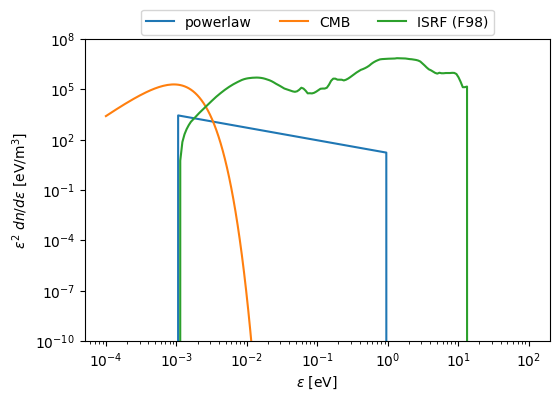

In [3]:
from photonField import CMB

field_cmb = CMB()

eps = np.logspace(-4, 2, 200) * eV
c = eps**2 / eV
plt.figure(dpi = 100)
y1 = c * field.getDensity(eps)
y2 = c * field_cmb.getDensity(eps)
y3 = c * isrf.getDensity(eps)
plt.plot(eps / eV, y1, label = "powerlaw")
plt.plot(eps / eV, y2, label = "CMB") 
plt.plot(eps / eV, y3, label = "ISRF (F98)")

plt.loglog()
plt.legend(ncol = 3, loc= "upper center", bbox_to_anchor=(0.5, 1.12))
plt.ylim([1e-10, 1e8])

plt.xlabel("$\epsilon$ [eV]")
plt.ylabel("$\epsilon^2 ~ dn/d\epsilon$ [eV/m$^3$]")
plt.show()

### 2. Create tables for wanted processes 

Here, all possible processes are used and the tables for the interactions are calculated. This process takes some time (ca. 45 minutes).

In [4]:
with warnings.catch_warnings(): # catch warnings from where density is approx 0 -> leads to divde errors
    warnings.simplefilter("ignore")
    
    # elasticscattering
    from calc_elasticscattering import process
    print("running ElasticScattering")
    process(field)
    process(isrf)
    
    # electro-magnetic
    from calc_electromagnetic import sigmaPP, sigmaDPP, sigmaICS, sigmaTPP, process
    print("running EMPairProduction")
    process(sigmaPP, field, "EMPairProduction")
    process(sigmaPP, isrf, "EMPairProduction")
    print("running EMDoublePairProduction")
    process(sigmaDPP, field, "EMDoublePairProduction")
    process(sigmaDPP, isrf, "EMDoublePairProduction")
    print("running EMTripletPairProduction")
    process(sigmaTPP, field, "EMTripletPairProduction")
    process(sigmaTPP, isrf, "EMTripletPairProduction")
    print("running EMInverseComptonScattering")
    process(sigmaICS, field, "EMInverseComptonScattering")
    process(sigmaICS, isrf, "EMInverseComptonScattering")

    # pair production
    from calc_pairproduction import process
    print("running ElectronPairProduction")
    process(field)
    process(isrf)
    # currently the spectrum can not be provided. Only as energy loss for primary

    # photo disintegration
    from calc_photodisintegration import processRate, processEmission
    print("running PhotoDissintegration")
    processRate(field)
    processRate(isrf)
    processEmission(field)
    processEmission(isrf)

    # photo pion production
    from calc_photopionproduction import process
    print("running PhotoPionProduction")
    process(field)
    process(isrf)
    print("finished rate calculation")

running ElasticScattering
running EMPairProduction
running EMDoublePairProduction
running EMTripletPairProduction
running EMInverseComptonScattering
running ElectronPairProduction
running PhotoDissintegration
running PhotoPionProduction
finished rate calculation


### 3. copy files to the share folder

The files stored in "CRPropa3-data/data" must been copied in the share folder of crpropa. 

    cp -r CRPropa3-data/data/* <installation-path>/share/crpropa/ 


For ElectronPairProduction a calculation of the spectrum is not possible. As the spectrum is not needed for the energy loss of the primary the following work around is possible:
- go to the share folder and in the subfolder ElectronPairProduction        

        cd <installation-path>/share/crpropa/ElectronPairProduction
- copy one spectrum file and rename CMB or IRB with the first 3 letters of your photon field (here *Pow* or *ISR*)

        cp spectrum_CMB.txt spectrum_<Pow/ISR>.txt

***Using this workaround and including the production of secondaries from the ElectrtonPairProduction module is not recomended!***

## Implementing custom PhotonField in CRPropa
for implemting your custom model in the final CRPropa simulation a PhotonField class is needed. Here are two different implementations possible. On the one hand a seperate python-based class with the analytical description of the photon density can be provided

In [5]:
from crpropa import * 

In [6]:
class CustomPhotonField(PhotonField):
    """ analogue implementation like above but inheriting from the CRPropa module for compatibility"""

    def __init__(self, name, norm = 1e20, slope = -2.75, eMin = 1e-3 * eV, eMax = 1 * eV):
        PhotonField.__init__(self)
        self.setFieldName(name)
        self.norm = norm
        self.slope = slope
        self.eMin = eMin
        self.eMax = eMax

    def getPhotnDensity(self, eps, z = 0.):
        return self.norm * (eps / eV)**self.slope * np.exp(- eps / self.eMax - self.eMin / eps)
    
    
    def getMinimumPhotonEnergy(self, z = 0):
        return self.eMin
    
    def getMaximumPhotonEnergy(self, z = 0):
        return self.eMax   

powerlowField = CustomPhotonField("PowerlawPhotonField")


On the other hand the Baseclass `TabularPhotonField` can be used to create a field on tabulated data. In the following the needed Scaling files will be created. In the end this files have to be copied to the sharefolder as described above

In [7]:
def createScaling(field, nBin = 100):
    """
        create the scaling files needed for the TabularPhotonField class. 

        field:  class instance for the description of the photon field as used for the generation of data files
        nBin:   number of log-bins between eMin and eMax. Should be increesed for large energy ranges 
    """

    eMin = field.getEmin()
    eMax = field.getEmax()
    
    eps = np.logspace(np.log10(eMin), np.log10(eMax), nBin)

    folder = "data/Scaling/"
    if not os.path.isdir(folder):
        os.makedirs(folder)
    
    header = "# Custom Photon Field: " + field.name + "\n"
    header = "# " + field.info + "\n"
    
    file_photonEnergy =  open(folder + field.name + "_photonEnergy.txt", "w")
    file_photonEnergy.writelines(header + "# photon energies in [J] \n")
    
    file_photonDensity = open(folder + field.name + "_photonDensity.txt", "w")
    file_photonDensity.writelines(header + "# Comiving photon number density in [m^-3] \n")    
    
    for e in eps:
        file_photonEnergy.write("{:.8e} \n".format(e))
        file_photonDensity.write("{:.8e} \n".format(field.getDensity(e)))

    file_photonDensity.close()
    file_photonEnergy.close()
createScaling(isrf)

now the files must be copied!

In [9]:
isrf_field = TabularPhotonField("ISRF", False)

## check implementation
To check the new photon fields all interactions on a photon fields are added to a ModuleList. If the instalation is done correctly this should run without any error and all interactions can be used. 

In [10]:
sim = ModuleList()

sim.add(ElasticScattering(powerlowField))
sim.add(ElasticScattering(isrf_field))


sim.add(EMPairProduction(powerlowField))
sim.add(EMPairProduction(isrf_field))

sim.add(EMDoublePairProduction(powerlowField))
sim.add(EMDoublePairProduction(isrf_field))

sim.add(EMTripletPairProduction(powerlowField))
sim.add(EMTripletPairProduction(isrf_field))

sim.add(EMInverseComptonScattering(powerlowField))
sim.add(EMInverseComptonScattering(isrf_field))

sim.add(ElectronPairProduction(powerlowField))
sim.add(ElectronPairProduction(isrf_field))

sim.add(PhotoDisintegration(powerlowField))
sim.add(PhotoDisintegration(isrf_field))

sim.add(PhotoPionProduction(powerlowField))
sim.add(PhotoPionProduction(isrf_field))

print("Everything works fine")

Everything works fine
